In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import math

import os


In [2]:
# Path to dataset
dataset_path = 'dataset/'

In [3]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4183 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.


In [5]:
# Load EfficientNetB0 (without classifier top)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 28s 2us/step


In [6]:
# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Callback
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
]

In [9]:
# Training
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

e:\Lang\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.3334 - loss: 1.1367 - val_accuracy: 0.3445 - val_loss: 1.0982 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 130s 990ms/step - accuracy: 0.3388 - loss: 1.1007 - val_accuracy: 0.3445 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 671ms/step - accuracy: 0.3493 - loss: 1.0998 - val_accuracy: 0.3445 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 712ms/step - accuracy: 0.3332 - loss: 1.0993 - val_accuracy: 0.3445 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 92s 702ms/step - accuracy: 0.3585 - loss: 1.0972 - val_accuracy: 0.3445 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 646ms/step - accuracy: 0.3329 - loss: 1.0989 - val_accuracy: 0.3445 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 655ms/step - accuracy: 0.34

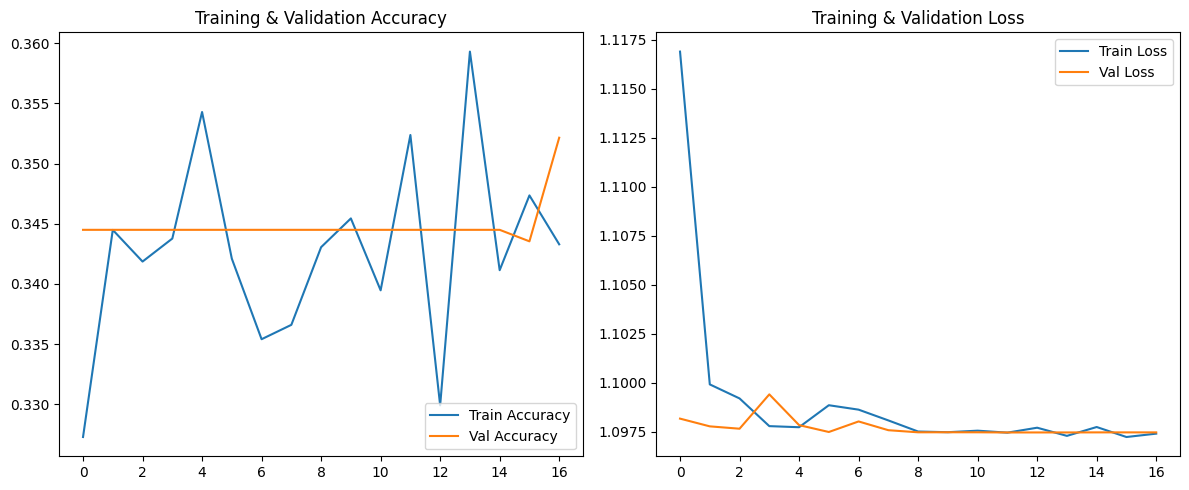

In [10]:
# Create graph for accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [11]:
# Data Validation predict
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 487ms/step


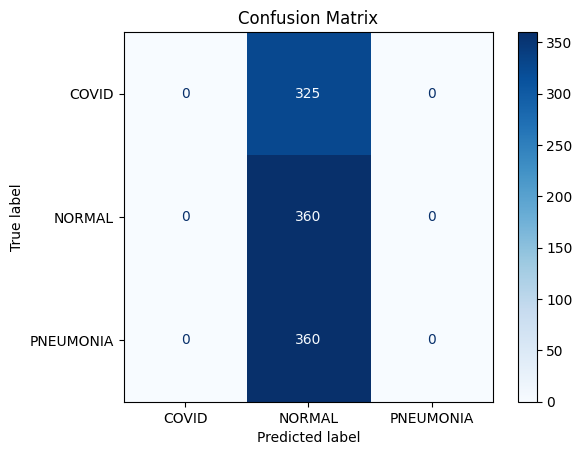

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [13]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       COVID       0.00      0.00      0.00       325
      NORMAL       0.34      1.00      0.51       360
   PNEUMONIA       0.00      0.00      0.00       360

    accuracy                           0.34      1045
   macro avg       0.11      0.33      0.17      1045
weighted avg       0.12      0.34      0.18      1045



e:\Lang\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Lang\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Lang\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Optional: Entropy and Loss Report
def categorical_crossentropy_loss(y_true, y_pred, epsilon=1e-10):
    y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = -np.sum(y_true_onehot * np.log(y_pred)) / y_pred.shape[0]
    return loss

In [15]:
entropy = categorical_crossentropy_loss(y_true, Y_pred)
print(f"Manual Entropy (Categorical Crossentropy): {entropy:.4f}")

Manual Entropy (Categorical Crossentropy): 1.0975


In [16]:
# Save model
model.save("model_covid_classifier.h5")

# Check mapping class
print("Class mapping:", train_generator.class_indices)

Class mapping: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
